# Streaming Algorithms & Event Systems

## What is an Event System?

* events are the primitivate/fundamental unit
    * vs., "row"
* data processing algorithms are streaming algorithms

## What is Streaming?

* (vs. traditional relational data processing)

In [3]:
import pandas as pd

table = pd.read_csv("tips.csv")

In [12]:
table.sample()

,total_bill,tip,sex,smoker,day,time,size
46,22.23,5.0,Male,No,Sun,Dinner,2


With tabular (batch) datasets we have access to the entire table (history/rows), so computing means is trivial.. 

In [5]:
table["total_bill"].mean()

19.78594262295082

In a streaming system, "rows" (events, observations) arrive one at a time,

In [9]:
stream = table.iterrows()

You can't compute a mean on a stream, as "there's no data yet", 

In [20]:
stream.mean()

AttributeError: 'generator' object has no attribute 'mean'

#### Estimating the Mean

In a streaming context we can only see one row at a time. 

Suppose we wish to estimate the mean total_bill for the week, the best we can do is compute a running estimate using running totals,

In [27]:
stream = table.iterrows()

running_sum = 0
running_count = 0
running_est = []
for index, row in stream:
    running_sum  += row["total_bill"]
    running_count += 1
    
    mean_estimate = running_sum / running_count
    
    running_est.append(mean_estimate)
    
    if (running_count % 20) == 0:
        print(f"Running est: {mean_estimate :.2f}")

Running est: 18.37
Running est: 18.86
Running est: 19.97
Running est: 19.32
Running est: 19.62
Running est: 19.78
Running est: 19.08
Running est: 19.28
Running est: 19.43
Running est: 19.81
Running est: 19.99
Running est: 19.76


As we can see, this approach only consistently approaches the true mean after c. 175 observations, 

<AxesSubplot:>

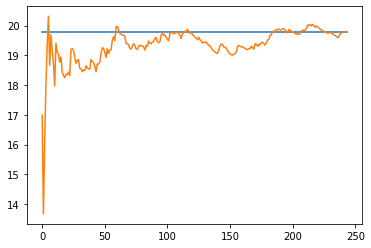

In [34]:
%matplotlib inline 

import seaborn as sns
sns.lineplot(x=range(0, running_count), y=[table["total_bill"].mean()] * running_count)
sns.lineplot(x=range(0, running_count), y=running_est)

Aproximately, in reverse, when does the line depart from the true mean?

In [47]:
true = table["total_bill"].mean()

for index, est in enumerate(reversed(running_est)):
    if abs(est - true) > 0.01*true:
        break

In [48]:
len(running_est) - index

220

## What are Events?

All datasets can be phrased as collections of events,

In [39]:
event = {
    "subject": "DOER",
    "verb": "DOES",
    "object": "ON",
    "context": {
        "time": "WHEN"
    }
}

"Event" models are helpful data structures in streaming system, and often even beyond them. 

Event data structures capture all the context around a piece of data -- typically relational systems are designed to ignore that context -- and keep only the essential stuff. 

### Comparing Relational to Event Systems

Relational systems often retain just enough information to enable "the system to work". Ie., not useful extra analytical data.

In [41]:
tickets_table = {
    (1, "Premium", "A13", "James Bond"),
    (2, "Premium", "A43", "James Bond"),
}

Event model "encourage" capturing this useful data,

In [49]:
tickets_stream = []

tickets_stream.append({
    "subject": {"name": "TICKET_OFFICE", "id": "London SW1 1AA"},
    "verb": "ISSUE_TICKET",
    "object": {"type": "CUSTOMER", "id": 13403943 },
    "context": {
        "time": "12pm",   
        "class": "Premium",  # CORE OPERATIONAL DATA
        "seat": "A13",       # CORE OPERATIONAL DATA
        "film": "James Bond" # CORE OPERATIONAL DATA
    }
})

As we can see here an "event model" captures lots of addition context around the source/dest/use of data. 

## How do you design an event system?

Event systems typically use an "append-only log". 

A primitivate database which can only be appended to!

In [65]:
elog = []
elog.append({
    "subject": "TICKET_SYSTEM",
    "verb": "ISSUE",
    "object": {"id": 13232, "type": "TICKET"},
    "context": {
        "time": "1pm"
    }
})

elog.append({
    "subject": "CUSTOMER",
    "verb": "PURCHASES",
    "object": {"id": 13232, "type": "TICKET"},
    "context": {
        "time": "1pm",
        "film": "James Bond"
    }
})

elog.append({
    "subject": "CUSTOMER",
    "verb": "ATTENDS",
    "object": "FILM",
    "context": {
        "time": "1pm",
        "film": "James Bond",
        "ticket": 1234
    }
})


In [66]:
elog

[{'subject': 'TICKET_SYSTEM',
  'verb': 'ISSUE',
  'object': {'id': 13232, 'type': 'TICKET'},
  'context': {'time': '1pm'}},
 {'subject': 'CUSTOMER',
  'verb': 'PURCHASES',
  'object': {'id': 13232, 'type': 'TICKET'},
  'context': {'time': '1pm', 'film': 'James Bond'}},
 {'subject': 'CUSTOMER',
  'verb': 'ATTENDS',
  'object': 'FILM',
  'context': {'time': '1pm', 'film': 'James Bond', 'ticket': 1234}}]

This limitation provides a lot of advantages!

Appending is a highly optimized operation so the log is very fast. No edits, deletes, etc. to support. Log is a great single-point-of-truth. 

## Processing an Append-Only Log

This system looks-for the purchasing of tickets and adds them to the db,

In [67]:
db_valid_tickets = []

for event in elog:
    if event["verb"] == "PURCHASES":
        db_valid_tickets.append(event["object"]["id"])

In [68]:
db_valid_tickets

[13232]

This system checks for valid tickets,

In [71]:
for event in elog:
    if event["verb"] == "ATTENDS":
        if event["context"]["ticket"] not in db_valid_tickets:
            # just to illustrate 
            raise Exception("Invalid Ticket")
            
            # more reasonable:
            # report_error("Invalid Ticket")
            # deny_entry(event) # here event = customer

Exception: Invalid Ticket

## Exercise (25 min)

* Consider a company/organization/industry 
    * consider a problem facing the organization
    * datasets & datasystem
    
* Eg., cinema, supermarket, ecommerce website
    * health data / health app tracking, ...
    * IoT -- all IoT systems are event systems
    
* Design some events that systems/users can cause
    * Eg., with cinema
    * subject: CUSTOMER, ATTENDANT, TICKET_SYSTEM, ...
    * verb: PURCHASE, ATTEND, ISSUE, ORDER, REFUND, 
        * object: SWEETS, TICKETS,

* Simulate a sequence of real-world (> 5) actions 
    * CUSTOMER PURCHASES TICKET
    * TICKET_SYSTEM ISSUES TICKET
    * CUSTOMER PURCHASES SWEETS
    * CUSTOMER ATTENDS FILM
    
* Using a for loop watch for properties of the event
    * and perform a reasonable action
    * eg., watch for "PURHCASES" & "SWEETS"
        * and print("DISCOUNT 10%!")
    

---

## How do you integrate analysis into event systems?

In [76]:
def recommend(film):
    db = {
        "James Bond": "Transformers"
    }
    
    return db[film]

In [78]:
for event in elog:
    if event["verb"] == "ATTENDS":
        print("We recommend you also see", recommend(event["context"]["film"]))

We recommend you also see Transformers
